In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# Introduction

The goal of this project is to predict price of the house based on given features. For this regression problem I'm going to present different machine learning approaches. The collected data contains 21613 observations and 21 features. Features:
- 'id':str – database identifier of the current row,
- 'date':str – pricing date,
- 'price':float – the price
- 'bedrooms':float – number of bedrooms,
- 'bathrooms':float – number of bathrooms,
- 'sqft_living':float – living space area,
- 'sqft_lot':int – lot area,
- 'floors':float – number of floors,
- 'waterfront':int – indicator of whether the property is facing water {0,1},
- 'view':int – quality of view from the property (0:4),
- 'condition':int – property condition (1:5),
- 'grade':int – property grade (1:13),
- 'sqft_above':int – living area above ground level,
- 'sqft_basement':int – area of basement,
- 'yr_built':int – year the building was built
- 'sqft_living15':float
- 'sqft_lot15':int 
- 'zipcode' - zipcode
- 'lat' - latitude
- 'long' - longitude

This is how the data looks like:

In [2]:
df = pd.read_excel("house.csv.xlsx")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2017-02-25 00:00:00,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df.shape

(21613, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null object
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null object
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(3), int64(15), object(3)
memory usage: 3.5+ MB


# Feature engineering

First step of data processing is to analyze and transform features that were collected. Fortunately there is no missing data.


First encountered problem in the feature analysis is that parameters: bathrooms and floors have wrong types. Excel wrongly converted float type values to datetime. Because there are some issues with changing dtype inside the function 'read_excel' I decided to change it manually with regexp.

In [5]:
def date_to_float(x):
    if len(str(x))>5 :
        return re.sub('-0?','.',str(x)[6:10])
    else:
        return str(x)
    
df.bathrooms = df.bathrooms.apply(date_to_float).astype(np.float64)
df.floors = df.floors.apply(date_to_float).astype(np.float64)

In [6]:
df[['bathrooms', 'floors']].head()

,bathrooms,floors
0,1.00,1.0
1,2.25,2.0
2,1.00,1.0
3,3.00,1.0
4,2.00,1.0


As we can see in the heatmap below, there are some features which are highly correlated to each other. There is a significant correlation between sqft parameters, for example: sqft_living and sqft_above or sqft_living15, what is not suprising. In my opinion they are still containing some additional value so there is no need to drop any of them.

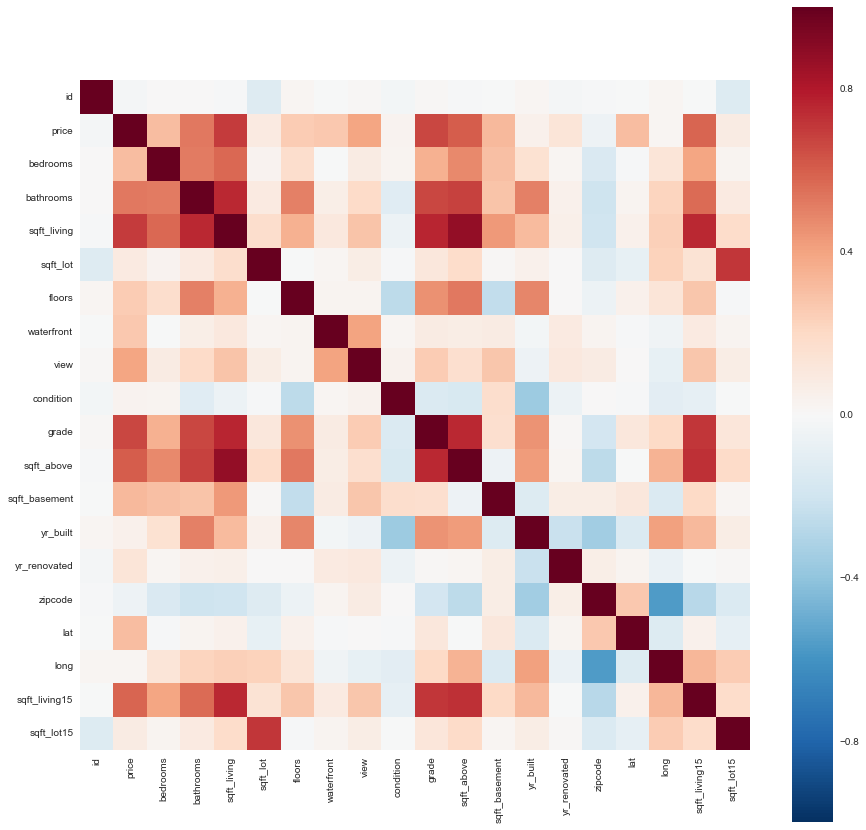

In [7]:
plt.figure(figsize=[15,15])
sns.heatmap(df.corr(),square=True)
plt.show()

ID feature is something that should be dropped because it is not providing any additional value. But as I was checking this column I noticed that there are 177 observations that have duplicates in the ID column. They have the same values in every feature except from Price and Date of pricing. This is a useful information for the model, because we can observe that price of the same house can change greatly in different time of pricing. So in this particular example I am not dropping duplicates in id column because this is not some kind of mistake in the data but rather additional information

In [8]:
print(len(df[df.id.duplicated(keep='first')==True]))
df[df.id.duplicated(keep=False)]

177


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,20140725T000000,430000.0,3,1.50,1580,5000,1.0,0,0,...,8,1290,290,1939,0,98117,47.6870,-122.386,1570,4500
94,6021501535,20141223T000000,700000.0,3,1.50,1580,5000,1.0,0,0,...,8,1290,290,1939,0,98117,47.6870,-122.386,1570,4500
313,4139480200,20140618T000000,1384000.0,4,3.25,4290,12103,1.0,0,3,...,11,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244
314,4139480200,20141209T000000,1400000.0,4,3.25,4290,12103,1.0,0,3,...,11,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244
324,7520000520,20140905T000000,232000.0,2,1.00,1240,12092,1.0,0,0,...,6,960,280,1922,1984,98146,47.4957,-122.352,1820,7460
325,7520000520,20150311T000000,240500.0,2,1.00,1240,12092,1.0,0,0,...,6,960,280,1922,1984,98146,47.4957,-122.352,1820,7460
345,3969300030,20140723T000000,165000.0,4,1.00,1000,7134,1.0,0,0,...,6,1000,0,1943,0,98178,47.4897,-122.240,1020,7138
346,3969300030,20141229T000000,239900.0,4,1.00,1000,7134,1.0,0,0,...,6,1000,0,1943,0,98178,47.4897,-122.240,1020,7138
371,2231500030,20141001T000000,315000.0,4,2.25,2180,10754,1.0,0,0,...,7,1100,1080,1954,0,98133,47.7711,-122.341,1810,6929
372,2231500030,20150324T000000,530000.0,4,2.25,2180,10754,1.0,0,0,...,7,1100,1080,1954,0,98133,47.7711,-122.341,1810,6929


In [9]:
df = df.drop('id', 1)

# Target variable

Important step of analyzing the variable is checking how target variable looks like. The distribution of data for price feature is right-skewed.

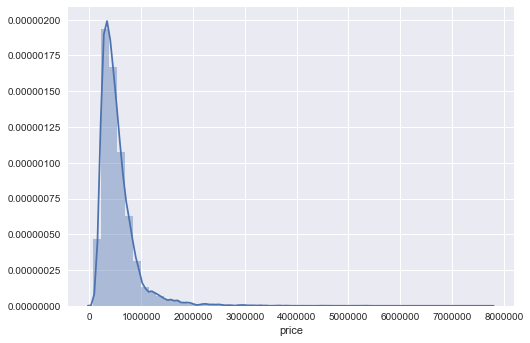

In [10]:
sns.distplot(df.price)
plt.show()

What I'm going to do is to take log from every value in the price column, so that its distribution would look more like a normal distribution.

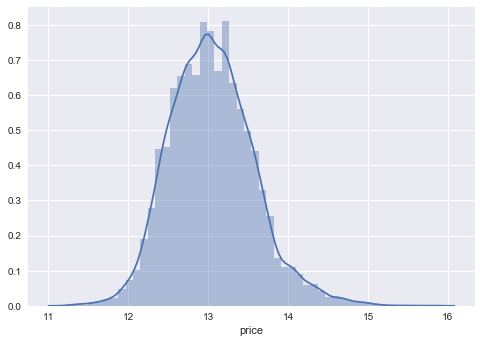

In [11]:
df.price = np.log(df.price)
sns.distplot(df.price)
plt.show()

# Area parameters:

The distribution of data for all area features looks pretty similar and is also right-skewed. We can see an example below:

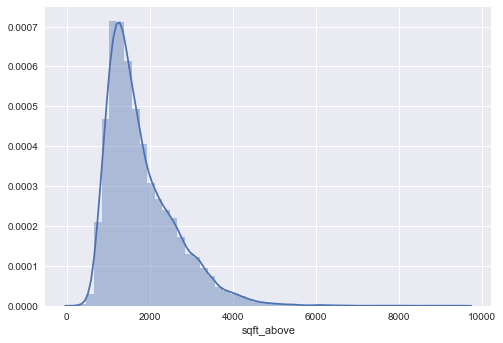

In [12]:
sns.distplot(df.sqft_above)
plt.show()

I'm going to do the same thing that I did for target variable and apply log transformation for all of these features

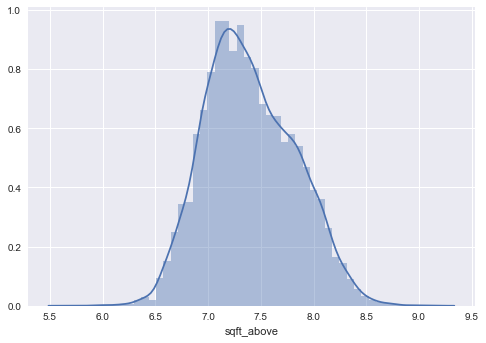

In [13]:
df.sqft_above = np.log(df.sqft_above)
sns.distplot(df.sqft_above)
plt.show()

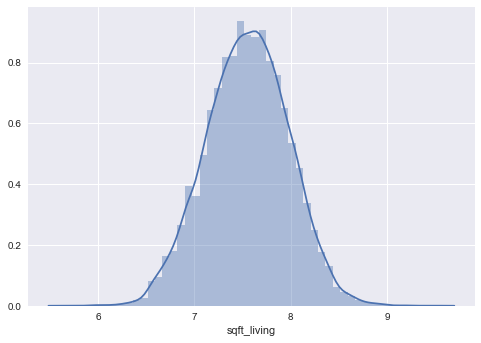

In [14]:
df.sqft_living = np.log(df.sqft_living)
sns.distplot(df.sqft_living)
plt.show()

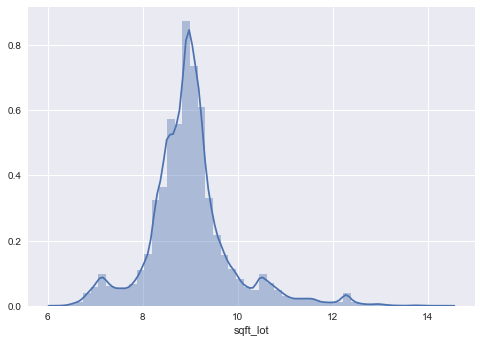

In [15]:
df.sqft_lot = np.log(df.sqft_lot)
sns.distplot(df.sqft_lot)
plt.show()

Most of houses do not have a basement. I'm going to take log value for other observations despite that

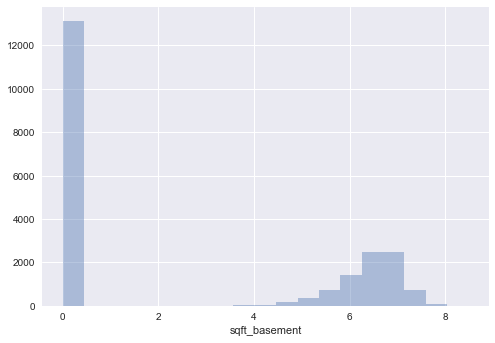

In [16]:
df.sqft_basement = np.log(df.sqft_basement+1)
sns.distplot(df.sqft_basement, kde=False)
plt.show()

In [17]:
df.sqft_living15 = np.log(df.sqft_living15)
df.sqft_lot15 = np.log(df.sqft_lot15)

# Categorical variables:

After most of continuous variables I will take care of categorical variables. Grade variable can be an important part in predicting price of the house. Naturally the higher the grade - the higher the price:

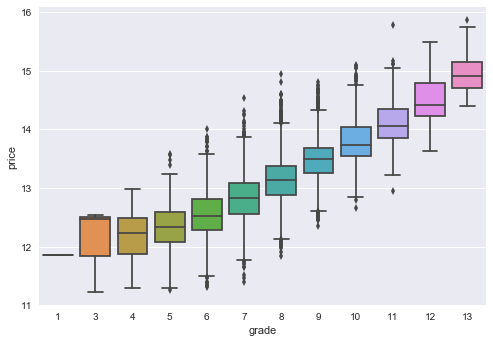

In [18]:
sns.boxplot(df.grade, df.price)
plt.show()

Categorical variables' type should be changed to 'category'

In [19]:
df.grade = df.grade.astype('category')
df.view = df.grade.astype('category')
df.condition = df.grade.astype('category')
df.waterfront = df.waterfront.astype('category')

# Year variables

There are also a few variables in the dataset which contains information about the year of some activities

Seasonality plays an important role in the housing market. That is why I should not only extract years of pricing but also define seasons of the year. People prefer buying houses during spring rather than winters.

In [20]:
def seasons(s):
    if s in ['03','04','05']:
        return 'spring'
    if s in ['06','07','08']:
        return 'summer'
    if s in ['09','10','11']:
        return 'autumn'
    if s in ['12','01','02']:
        return 'winter'

df.date = df.date.apply(lambda x: x[:4]+'_'+seasons(x[4:6])).astype('category')
df.date.head()

0    2014_autumn
1    2014_winter
2    2015_winter
3    2014_winter
4    2015_winter
Name: date, dtype: category
Categories (6, object): [2014_autumn, 2014_spring, 2014_summer, 2014_winter, 2015_spring, 2015_winter]

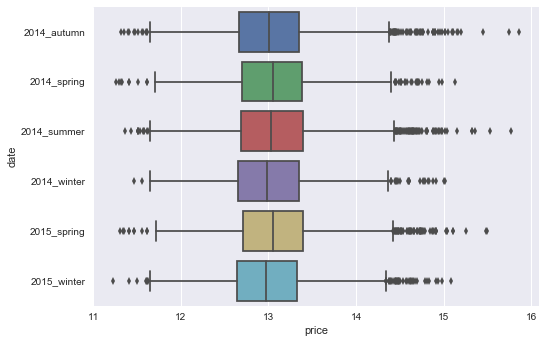

In [21]:
sns.boxplot(df.price, df.date, orient='h')
plt.show()

Yr_renovated column has many zero values. There is a histogram below for non-zero values.

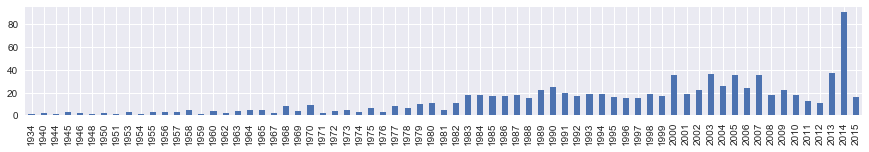

In [22]:
df.yr_renovated.value_counts()[1:].sort_index().plot(kind='bar', figsize=(15,2))
plt.show()

My idea is to change this numerical columns to categorical by creating bins for this distribution and also add one more category for zero-values

In [ ]:
cut = pd.cut(df[df.yr_renovated!=0].yr_renovated,4, labels=['1900-1954','1955-1975','1976-1994','1995-2015'])
df.yr_renovated = pd.concat([df.yr_renovated, cut], 1).fillna(axis=1, method='ffill')[[1]]
df.yr_renovated  = df.yr_renovated.astype('category')

I also transformed yr_built variable to information about how old the house is.

In [23]:
df.yr_built = 2015 - df.yr_built

# Location variables:

Now let's visualize how our houses are located.

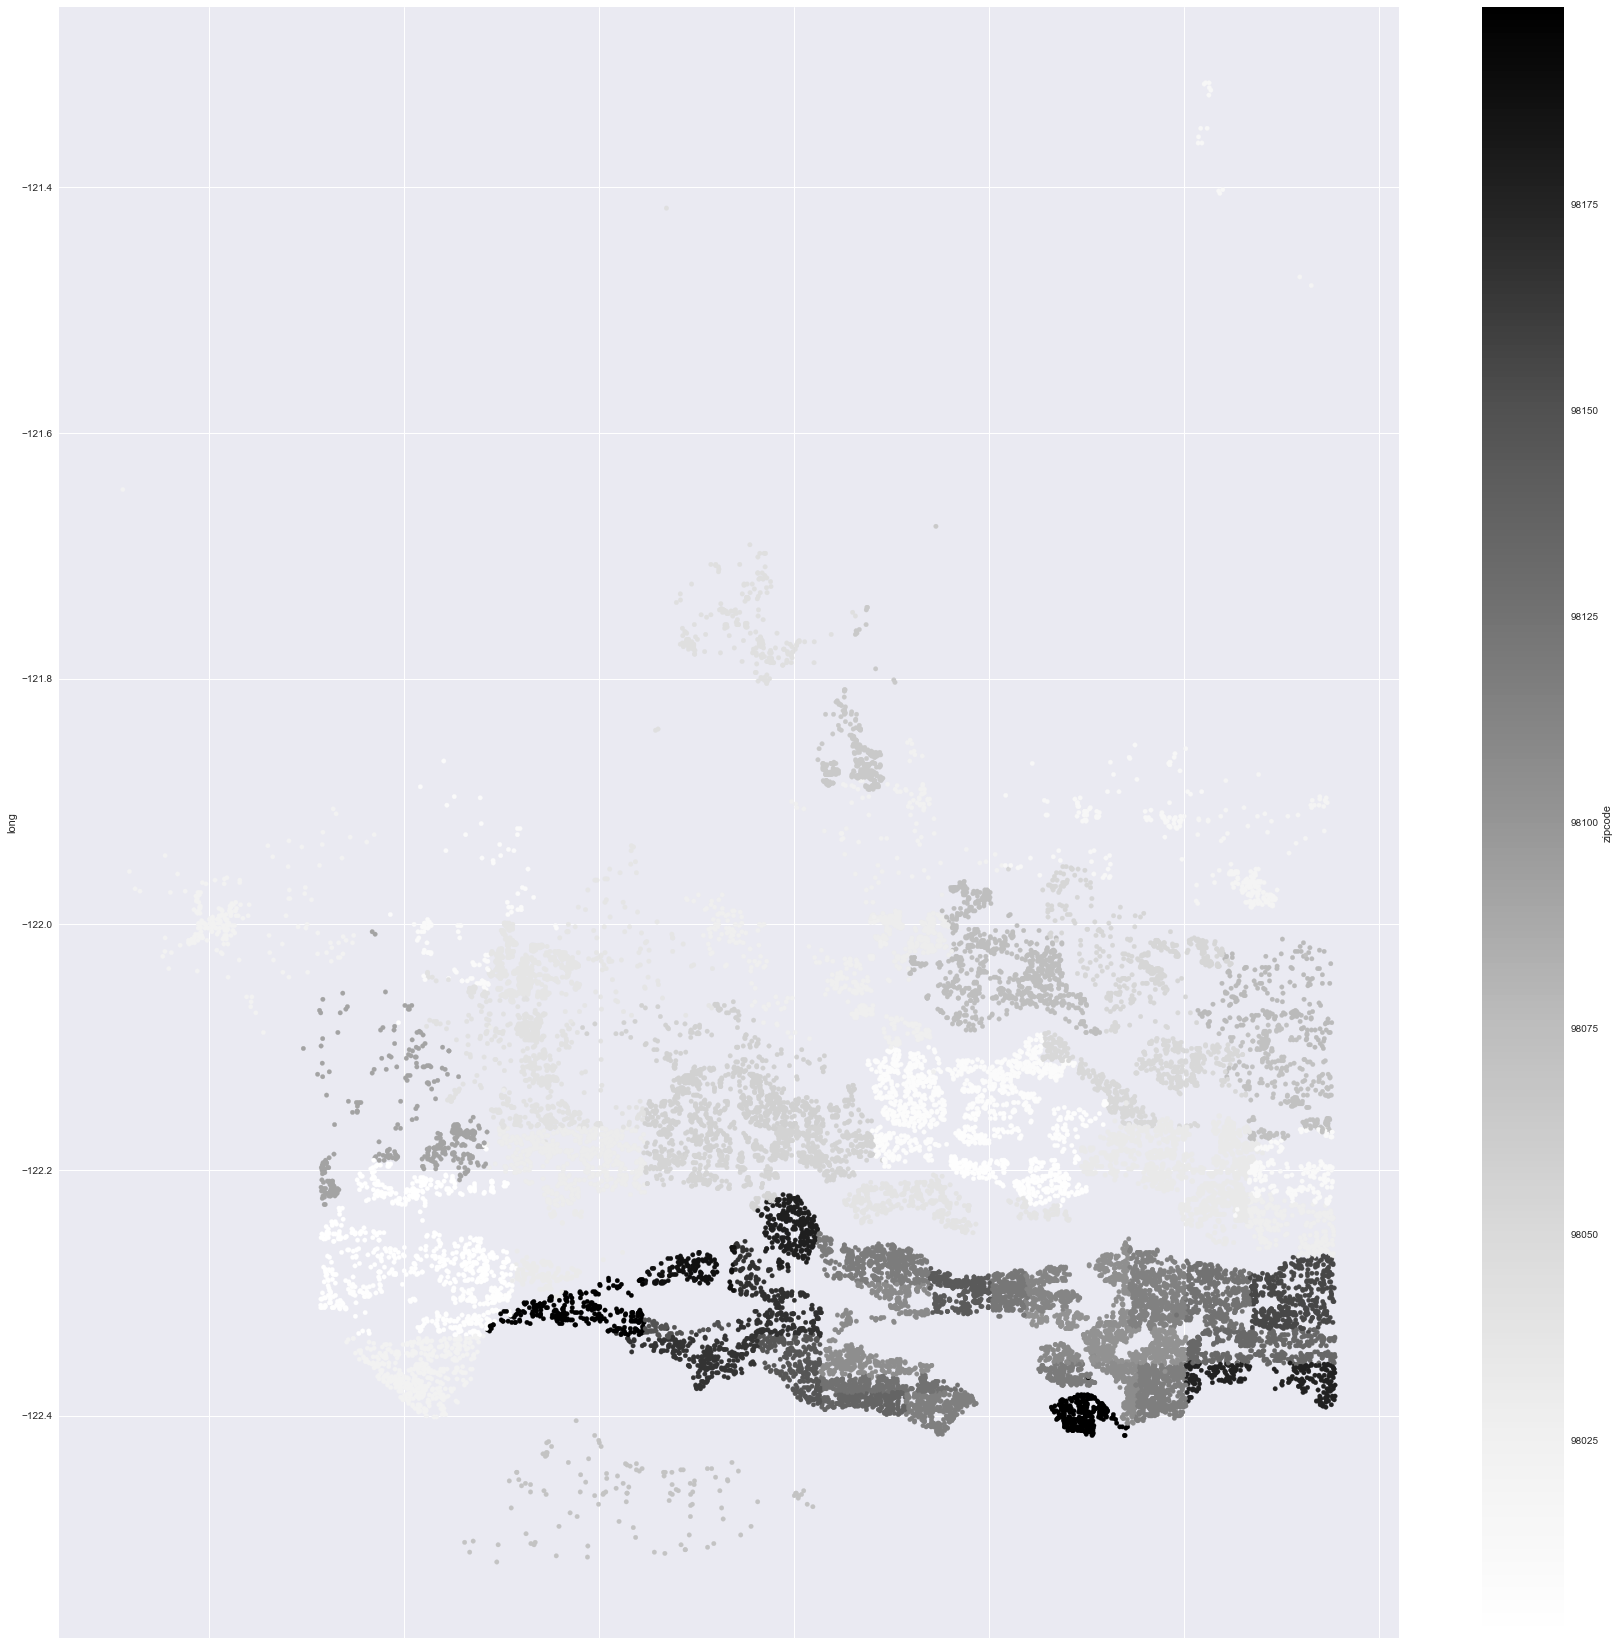

In [24]:
df.plot(kind='scatter', x='lat', y='long', figsize=(30,30), c = 'zipcode')
plt.show()

Houses in the data are located in areas with 70 different zipcodes. This number is pretty high, so probably good idea is to reduce this number by combining locations which are close to each other. In order to reduce the number of categories in the zipcode column, I'm going to use KMeans algorithm. Every point in the plot below represents mean coordinates for houses within the same zipcode. KMeans is finding clusters which contains the points which are relatively close to each other. So we are ending up with 10 clusters (labeled with different colours in the plot) instead of 70.

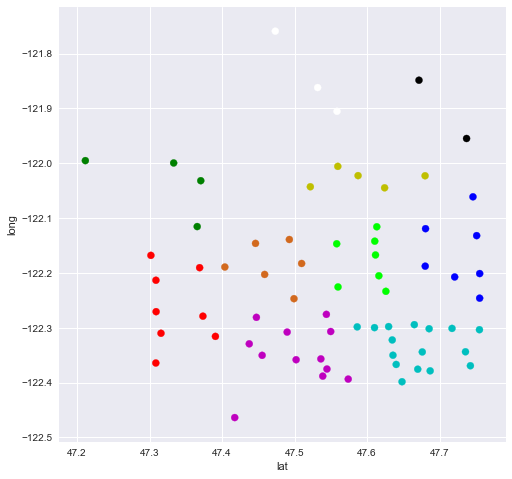

In [25]:
centroids = df.groupby('zipcode')['lat','long'].mean()
km = KMeans(n_clusters = 10)
km.fit(centroids)
colors = np.array(['c','m','y','k','r','g','b','w','lime','chocolate'])
centroids.plot(kind='scatter', x='lat', y='long', figsize=(8,8), c = colors[km.labels_],s=50)
plt.show()

In [26]:
df['location'] = df.zipcode.map(dict(zip(centroids.index, km.labels_))).astype('category')
df.drop('zipcode',1, inplace=True)

Now I can apply one hot encoding on the categorical features with get_dummies function

In [27]:
df = pd.get_dummies(df, drop_first=True)

# Sets preparing

This is how our data looks like after preprocessing step. We end up with 62 features.

In [28]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,...,grade_13,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9
0,12.309982,3,1.00,7.073270,8.639411,1.0,7.073270,0.000000,60,0,...,0,0,0,0,0,0,0,0,0,1
1,13.195614,3,2.25,7.851661,8.887653,2.0,7.682482,5.993961,64,1991,...,0,0,0,0,0,0,0,0,0,0
2,12.100712,2,1.00,6.646391,9.210340,1.0,6.646391,0.000000,82,0,...,0,0,0,0,0,0,1,0,0,0
3,13.311329,4,3.00,7.580700,8.517193,1.0,6.956545,6.814543,50,0,...,0,1,0,0,0,0,0,0,0,0
4,13.142166,3,2.00,7.426549,8.997147,1.0,7.426549,0.000000,28,0,...,0,0,1,0,0,0,0,0,0,0


In [29]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'date_2014_spring',
       'date_2014_summer', 'date_2014_winter', 'date_2015_spring',
       'date_2015_winter', 'waterfront_1', 'view_3', 'view_4', 'view_5',
       'view_6', 'view_7', 'view_8', 'view_9', 'view_10', 'view_11', 'view_12',
       'view_13', 'condition_3', 'condition_4', 'condition_5', 'condition_6',
       'condition_7', 'condition_8', 'condition_9', 'condition_10',
       'condition_11', 'condition_12', 'condition_13', 'grade_3', 'grade_4',
       'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10',
       'grade_11', 'grade_12', 'grade_13', 'location_1', 'location_2',
       'location_3', 'location_4', 'location_5', 'location_6', 'location_7',
       'location_8', 'location_9'],
      dtype='object')

Now is the time to creat inputs and labels for the model and split the data to 3 datasets: train, test and validation

In [30]:
x = df.drop('price',1)
y = df['price']
x, x_test, y, y_test = train_test_split(x, y, test_size = 0.2, random_state=123)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state=123)

The next step is normalization of a few features. There is a fit_transform method for train set and transform for test and validation set

In [31]:
for col in ['bathrooms', 'bedrooms', 'floors']:
    scaler = StandardScaler()
    x_train[col] = scaler.fit_transform(x_train[col].reshape(-1,1))
    x_test[col] = scaler.transform(x_test[col].reshape(-1,1))
    x_val[col] = scaler.transform(x_val[col].reshape(-1,1)) 

# Model selection and tuning

Now with the data prepared for training we can start creating some base models and checking their accuracy. Evaluation of the    resuts will be done using two metrics: R^2 coefficient and mean square error.

In [32]:
results = pd.DataFrame()

In [33]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MSE = {}'.format(mean_squared_error(y_test, y_pred)))
results = results.append({'model':'Linear Regression',
                        'mean_square_error':mean_squared_error(y_test, y_pred), 
                        'R^2':model.score(x_test, y_test)}, ignore_index=True)

MSE = 0.052655383488482636


In [34]:
model = Ridge()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MSE = {}'.format(mean_squared_error(y_pred,y_test)))
results = results.append({'model':'Ridge Regression',
                        'mean_square_error':mean_squared_error(y_test, y_pred), 
                        'R^2':model.score(x_test, y_test)}, ignore_index=True)

MSE = 0.05263269408042754


In [35]:
from sklearn.svm import SVR
model = SVR()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MSE = {}'.format(mean_squared_error(y_test, y_pred)))
results = results.append({'model':'SVR',
                        'mean_square_error':mean_squared_error(y_test, y_pred), 
                        'R^2':model.score(x_test, y_test)}, ignore_index=True)

MSE = 0.05655658739676831


In [36]:
model = RandomForestRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MSE = {}'.format(mean_squared_error(y_test, y_pred)))
results = results.append({'model':'RF before tuning',
                        'mean_square_error':mean_squared_error(y_test, y_pred), 
                        'R^2':model.score(x_test, y_test)}, ignore_index=True)

MSE = 0.03509660665610008


In [37]:
model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MSE = {}'.format(mean_squared_error(y_test, y_pred)))
results = results.append({'model':'XGBoost before tuning',
                        'mean_square_error':mean_squared_error(y_test, y_pred), 
                        'R^2':model.score(x_test, y_test)}, ignore_index=True)

MSE = 0.03710344432041767


As we can see XGBoost and RandomForest models are outperforming simple and regularized linear regression. Now I will try to tune hyperparameters and I will do it only for two models with the best scores. Let's start with RF:

In [38]:
grid = GridSearchCV(RandomForestRegressor(),
                    cv=5,
                    param_grid={'n_estimators':[10,50,100], 
                                'min_samples_split':[3,5,10], 
                                'min_samples_leaf':[1,5,10]}                  
)
grid.fit(x_val, y_val)
grid.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 11.0min finished


{'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}

In [39]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf= 1, min_samples_split= 3)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MSE = {}'.format(mean_squared_error(y_test, y_pred)))
results = results.append({'model':'RF after tuning',
                        'mean_square_error':mean_squared_error(y_test, y_pred), 
                        'R^2':model.score(x_test, y_test)}, ignore_index=True)

MSE = 0.03317963292686539


To better understand our data we can also use one of the properties of RandomForrest model and check which features have the highest impact on the model performance.

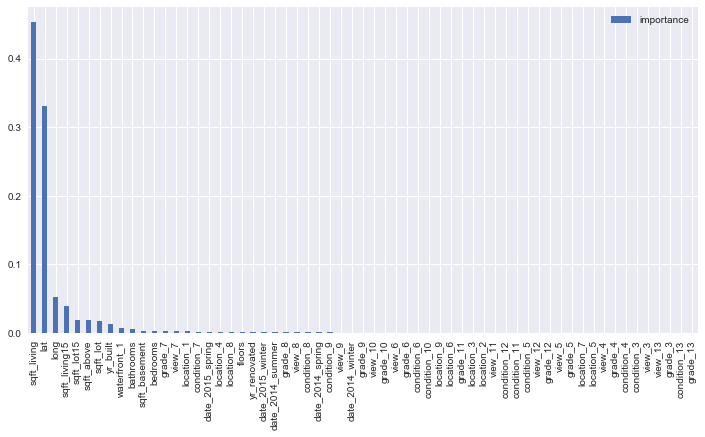

In [40]:
importance = pd.DataFrame({'importance':model.feature_importances_}, 
                          index = x_train.columns).sort_values('importance', ascending=False)
importance.plot(kind='bar', figsize=(12,6))
plt.show()

As we can see in the graph above, feature "sqft_living" is the most important feature in predicting prices of unseen houses based on RF model. The localization of the house, waterfront and other area features are also essential

Now I will try to tune XGBoost model parameters. Because there is so much parameters to tune in XGBoostRegressor, I'm starting grid search optimization with a few important parameters for creating single trees (max_depth, min_child_weight) and then for the given parameters I will try to tune the regularization.

In [41]:
grid = GridSearchCV(XGBRegressor(n_estimators=100, 
                                 learning_rate=0.3),
                    param_grid={'max_depth': [3,5,7,9], 
                                'min_child_weight':[1,3,5]}, 
                    cv=5, 
)
grid.fit(x_val, y_val)
grid.best_params_

{'max_depth': 5, 'min_child_weight': 5}

In [42]:
grid = GridSearchCV(XGBRegressor(n_estimators=100, 
                                 learning_rate=0.3),
                    param_grid={'max_depth': [4,5,6], 
                                'min_child_weight':[4,5,6]}, 
                    cv=5, 
)
grid.fit(x_val, y_val)
grid.best_params_

{'max_depth': 5, 'min_child_weight': 4}

In [51]:
grid = GridSearchCV(XGBRegressor(n_estimators=100, 
                                 learning_rate= 0.3, 
                                 max_depth= 5, 
                                 min_child_weight= 4),
                    cv=5,
                    param_grid={'reg_alpha':[0,0.1,0.01,0.5],
                               'reg_lambda':[0,0.1,0.01,0.5]}
)
grid.fit(x_val,y_val)
grid.best_params_

{'reg_alpha': 0.5, 'reg_lambda': 0}

I increase the number of trees and lower the learning rate to hopefully get better results. Other parameters are got from grid search optimization.

In [56]:
model = XGBRegressor(n_estimators = 1000, 
                     learning_rate = 0.1, 
                     min_child_weight = 4, 
                     max_depth = 5,
                     reg_alpha = 0.5,
                     reg_lambda = 0                     
)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MSE = {}'.format(mean_squared_error(y_test, y_pred)))
results = results.append({'model':'XGBoost after tuning',
                        'mean_square_error':mean_squared_error(y_test, y_pred), 
                        'R^2':model.score(x_test, y_test)}, ignore_index=True)

MSE = 0.02817164820869595


# Summary of results

The results of testing are presented in the table below:

In [57]:
results.set_index('model')

,R^2,mean_square_error
model,,
Linear Regression,0.814387,0.052655
Ridge Regression,0.814467,0.052633
SVR,0.800635,0.056557
RF before tuning,0.876282,0.035097
XGBoost before tuning,0.869208,0.037103
RF after tuning,0.883040,0.033180
XGBoost after tuning,0.900693,0.028172


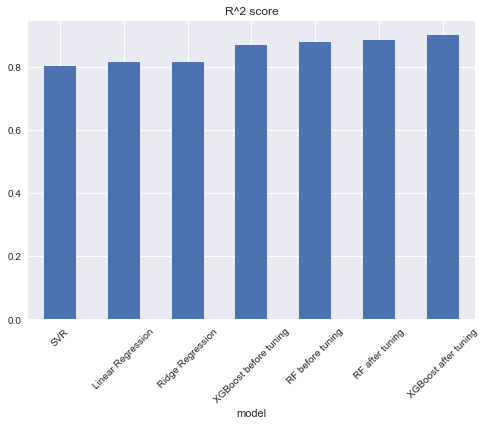

In [58]:
results.set_index('model')['R^2'].sort_values().plot('bar', rot=45, title='R^2 score')
plt.show()

As it could be observed in the table above using RF and XGBoost models is minimizing MSE score. Tuning parameters for this two algorithms also increased their overall performance. The best result for both metrics are for tuned XGBoost model: R^2 = 0.9 and MS error = 0.28

Future work:
- One of the ideas to boost model performance is using stacking method to average our best base models. 
- I could also try other variations of ensemble regression models whch were not include in these tests, for example: GBR. 
- I could consider applying some outlier detection techniques.
- Spend more time on feature transformation to look whether some small changes in the data could increase the model performance.